In [18]:
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import triangulate
import shapely.wkt
import pandas as pd
import geopandas as gpd
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import time

from shapely.ops import cascaded_union
from sklearn.cluster import KMeans


def to_triangles(polygon):
    poly_points = []

    gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.1).exterior]}).explode().reset_index()
    for geom in gdf_poly_exterior.geometry:
        poly_points += np.array(geom.coords).tolist()

    try:
        polygon.interiors[0]
    except:
        poly_points = poly_points
    else:
        gdf_poly_interior = gpd.GeoDataFrame({'geometry': [polygon.interiors]}).explode().reset_index()
        for geom in gdf_poly_interior.geometry:
          poly_points += np.array(geom.coords).tolist()

    poly_points = np.array([item for sublist in poly_points for item in sublist]).reshape(-1,2)

    poly_shapes, pts = voronoi_regions_from_coords(poly_points, polygon)
    gdf_poly_voronoi = gpd.GeoDataFrame({'geometry': poly_shapes}).explode().reset_index()

    tri_geom = []
    for geom in gdf_poly_voronoi.geometry:
        inside_triangles = [tri for tri in triangulate(geom) if tri.centroid.within(polygon)]
        tri_geom += inside_triangles

    gdf_poly_triangles = gpd.GeoDataFrame({'geometry': tri_geom}, crs=4326)

    return gdf_poly_triangles

def point_in_triangle(poly_tri):
    v1, v2, v3 = poly_tri.exterior.coords[0:3]
    v2_scaled = [v2[0] - v1[0], v2[1] - v1[1]]
    v3_scaled = [v3[0] - v1[0], v3[1] - v1[1]]
    
    s, t = random.uniform(0,1), random.uniform(0,1)
    if s+t > 1:
        s = 1 - s
        t = 1 - t
    two_weighted = [v2_scaled[0] * s, v2_scaled[1] * s]
    three_weighted = [v3_scaled[0] * t, v3_scaled[1] * t]

    new_point = np.add(np.add(two_weighted, three_weighted), [v1[0], v1[1]])
    
    return shapely.Point(new_point)

def area_dist(polys):
    total_area = sum(polys.area)
    cum_dist = []
    for i, poly in enumerate(polys):
        if i > 0:
            last_value = cum_dist[i-1]
        else:
            last_value = 0
        cum_dist.append(last_value + (poly.area / total_area))
    
    return cum_dist

def random_poly(polys):
    cum_dist = area_dist(polys)
    rand = random.random()
    index = cum_dist.index(next(x for x in cum_dist if x > rand), 0)
    return polys[index]

def tri_test():
    poly_input = gpd.read_file("scenarios/london_houses/london.geojson")['geometry'][0]

    poly_tri_4326 = to_triangles(poly_input)
    poly_tri_3857 = poly_tri_4326.to_crs('EPSG:3857')

    triangle_points = []

    start_time = time.time()

    print(len(poly_tri_3857['geometry']))

    num_tri = len(poly_tri_3857['geometry'])
    points_goal = 1000

    for i in range(points_goal):
        tri = random_poly(poly_tri_3857['geometry']) 
        x = point_in_triangle(tri)
        triangle_points.append(x)

    triangle_points = gpd.GeoDataFrame(pd.DataFrame(triangle_points, columns=['geometry']), geometry='geometry')
    end_time = time.time()

    fig, ax = plt.subplots(1,3, figsize=(15,10))

    poly_tri_3857.plot(ax=ax[0], facecolor='none', edgecolor='black')

    poly_tri_3857.plot(ax=ax[1], facecolor='none', edgecolor='black')
    triangle_points.plot(ax=ax[1], color='red', markersize=0.5)

    triangle_points.plot(ax=ax[2], color='red', markersize=0.5)

    plt.show()

    print("Time taken for generation: ", end_time - start_time)

Now we have chosen our triangle. How do we go about generating a random point inside of it? Alpha Wolfram has a great post about this. The gist of it: We assume one point of the triangle to be at the origin of our coordinate system [0, 0]. For the other two points we create two random weights in the range of [0, 1]. We multiply (scale) each point by one of the weights and add both points up. Tada random points!

Original gen from wolframalpha explanation, limiting points in the triangle comes from the Points with Triangulation paper


C:\Users\Paddy\AppData\Local\Temp\ipykernel_15588\1091718002.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.1).exterior]}).explode().reset_index()
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Li

<AxesSubplot: >

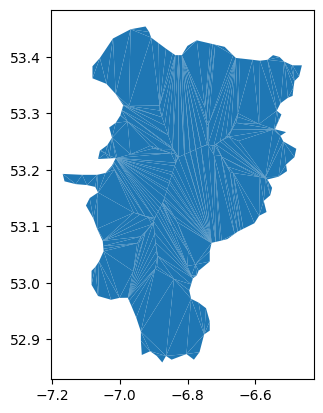

In [16]:
def voronoi_gen(poly, vor_num):
    poly = poly.to_crs(epsg=3857)
    # Voronoi centroids are generated based on the specified generation type
    vor_centroids = kmeans_centroids(poly, 500, vor_num, 0)
    
    # Setting crs to meter based projection
    gdf_proj = vor_centroids.set_crs(poly.crs)

    # Convert the boundary geometry into a union of the polygon
    boundary_shape = cascaded_union(poly.geometry)
    coords = points_to_coords(gdf_proj.geometry)

    # Calculating the voronoi regions
    region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

    # Create GeoDataFrame of the Voronoi Polygons

    df = pd.DataFrame(list(region_polys.items()), columns=['index','geometry'])
    gdf_poly = gpd.GeoDataFrame(df, geometry='geometry')
    gdf_poly.crs = poly.crs

    return gdf_poly

# This function takes in a Shapely Polygon, number of points, number of clusters, and a generation type, and returns
# a GeoDataFrame of Points, representing centroids produced by a Kmeans clustering of uniformly random points generated
# inside of the polygon. The centroids will either be generated using uniform generation, with points distributed
# uniformly in the polygon, or with points concentrated towards the polygon centroid.

def kmeans_centroids(poly, num_points, num_cluster):
    # Points are generated randomly in the polygon

    source = random_point_gen(poly['geometry'][0], num_points)

    source = source.set_crs(epsg=3857)

    # The geometries of the Shapely points are converted to a numpy array for use in the kmeans algorithm
    feature_coords = np.array([[e.x, e.y] for e in source.geometry])

    # A kmeans object is created using the specified number of clusters
    kmeans = KMeans(num_cluster)
    kmeans.fit(feature_coords)

    # The cluster centres are stored as centroids, and this list is put into a GeoDataFrame and returned
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))
    gdf.crs = source.crs
    return gdf

def to_triangles(polygon):
    poly_points = []

    gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.1).exterior]}).explode().reset_index()
    for geom in gdf_poly_exterior.geometry:
        poly_points += np.array(geom.coords).tolist()

    try:
        polygon.interiors[0]
    except:
        poly_points = poly_points
    else:
        gdf_poly_interior = gpd.GeoDataFrame({'geometry': [polygon.interiors]}).explode().reset_index()
        for geom in gdf_poly_interior.geometry:
          poly_points += np.array(geom.coords).tolist()

    poly_points = np.array([item for sublist in poly_points for item in sublist]).reshape(-1,2)

    poly_shapes, pts = voronoi_regions_from_coords(poly_points, polygon)
    gdf_poly_voronoi = gpd.GeoDataFrame({'geometry': poly_shapes}).explode().reset_index()

    tri_geom = []
    for geom in gdf_poly_voronoi.geometry:
        inside_triangles = [tri for tri in triangulate(geom) if tri.centroid.within(polygon)]
        tri_geom += inside_triangles

    gdf_poly_triangles = gpd.GeoDataFrame({'geometry': tri_geom}, crs=4326)

    return gdf_poly_triangles

poly_input = gpd.read_file("scenarios/kildare/kildare.geojson")['geometry'][0]

poly_triangles = to_triangles(poly_input)

poly_triangles.plot()